## Load Olivetti Faces Dataset

In [1]:
# Import dependencies
from sklearn.datasets import fetch_olivetti_faces

# Load the Olivetti faces dataset
data = fetch_olivetti_faces()
X, y = data.data, data.target

## Split the data into training, validation and test using stratified sampling.

**60% training, 20% validation** and **20% test** ensures having enough data to train the model and sufficient data to evaluate it.

In [2]:
# Split the data into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print(f"Training set size: {X_train.shape[0]}, Validation set size: {X_val.shape[0]}, Test set size: {X_test.shape[0]}")


Training set size: 240, Validation set size: 80, Test set size: 80


## Using K-Fold Cross Validation, train SVC to predict which person represents a picture and evaluate on the validation set

In [3]:
# Train classifier using k-fold cross-validation
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np

clf = SVC(kernel='linear', random_state=42)
skf = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(clf, X_train, y_train, cv=skf)
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")

# Evaluate on the validation set
clf.fit(X_train, y_train)
val_score = clf.score(X_val, y_val)
print(f"Validation Accuracy: {val_score:.4f}")

Cross-Validation Accuracy: 0.9292
Validation Accuracy: 0.9625


## Use K-Means to reduce dimensionality of dataset

The expected number of clusters is 40 as there are 40 unique people in the dataset. However, the result shows that there are multiple cluster values that have a high silhouette score (shown as red dots on the diagram). This makes the result of the training unreliable for the purpose of this model.

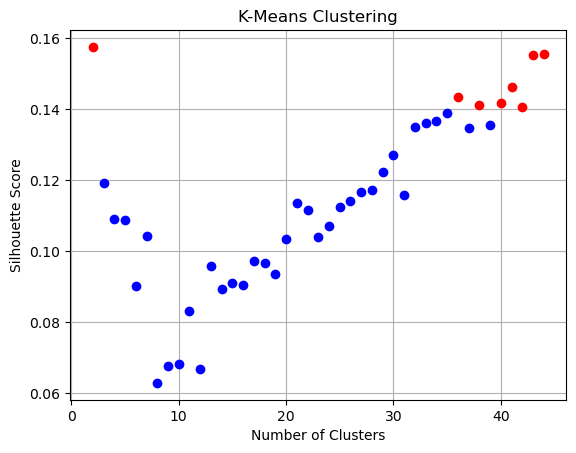

Best Silhouette Score: 0.1575 with 2 clusters
Clusters with silhouette score greater than 0.14:
Cluster 2: 0.1575
Cluster 36: 0.1435
Cluster 38: 0.1412
Cluster 40: 0.1417
Cluster 41: 0.1461
Cluster 42: 0.1407
Cluster 43: 0.1551
Cluster 44: 0.1554


In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from warnings import filterwarnings
import matplotlib.pyplot as plt

filterwarnings('ignore')

# Dimensionality reduction using K-Means and silhouette score
best_score = -1
best_k = 0
silhouette_scores = []
end = 45

# Evaluate silhouette score for different cluster numbers
for k in range(2, end):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_train)
    score = silhouette_score(X_train, labels)
    silhouette_scores.append(score)
    if score > best_score:
        best_score = score
        best_k = k

# Create a plot of k vs silhouette score with markers, annotations, and grid lines
for i, score in enumerate(silhouette_scores):
    color = 'red' if score >= 0.14 else 'blue'
    plt.plot(i + 2, score, marker='o', color=color)

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('K-Means Clustering')
plt.grid(True)
plt.show()

# Print clusters with silhouette score greater than 0.14
print(f"Best Silhouette Score: {best_score:.4f} with {best_k} clusters")
print("Clusters with silhouette score greater than 0.14:")
# Assign values greater than 0.14 to an array called k_values and print them
k_values = []
for k, score in enumerate(silhouette_scores):
    if score >= 0.14:
        k_values.append(k+2)
        print(f"Cluster {k+2}: {score:.4f}")

In the silhoutte diagram, when the cluster is set to 40, the data distribution is uneven with the mean silhouette coefficient either exceeded or untouched by most silhoutte instances. 

Also, since some instances lean towards -1, some of the data points have been assigned to the wrong cluster.

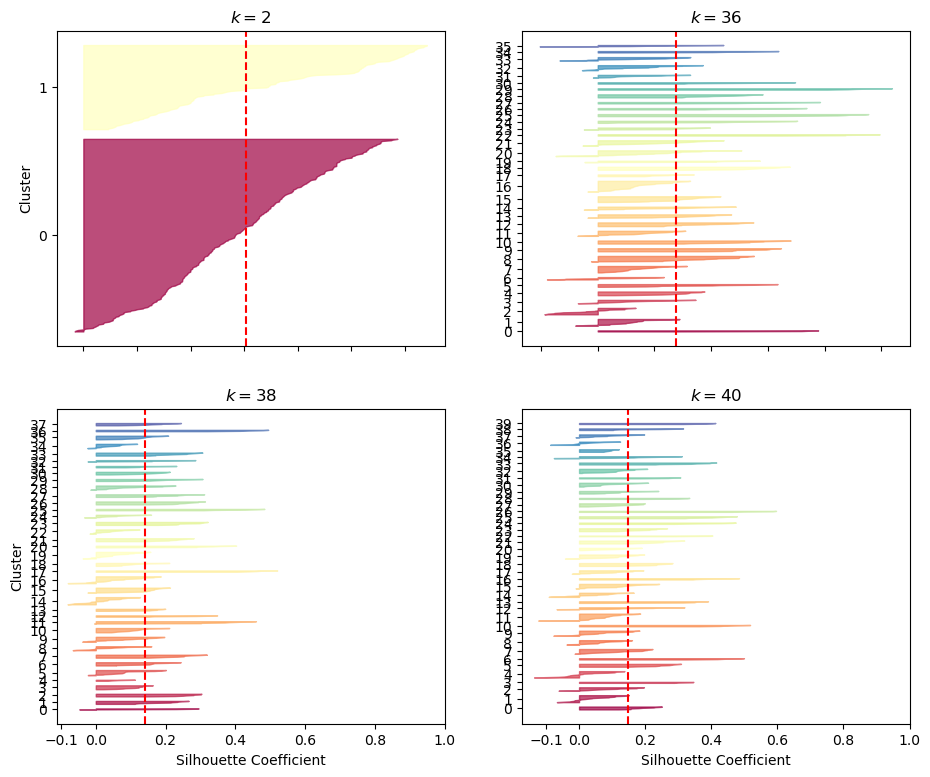

In [5]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.ticker import FixedLocator, FixedFormatter

# Fit KMeans models for different values of k
k_values = [KMeans(n_clusters=i).fit(X) for i in range(2, 41)]

# Calculate silhouette scores for each k
silhouette_scores = [silhouette_score(X, k.labels_) for k in k_values]

# extra code – this cell generates and saves Figure 9–10

plt.figure(figsize=(11, 9))

for idx, k in enumerate((2, 36, 38, 40), start=1):
    plt.subplot(2, 2, idx)
    
    y_pred = k_values[k - 2].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 38):
        plt.ylabel("Cluster")
    
    if k in (38, 40):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

## Train classifier using set from K-Means

In [6]:
from sklearn.metrics import accuracy_score

# Train classifier on the reduced set using K-Means cluster

kmeans = KMeans(n_clusters=40, random_state=42)
X_train_reduced = kmeans.fit_transform(X_train)

# Re-train classifier on reduced features

clf.fit(X_train_reduced, y_train)
X_val_reduced = kmeans.transform(X_val)
val_predictions = clf.predict(X_val_reduced)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy after Dimensionality Reduction: {val_accuracy:.4f}")

Validation Accuracy after Dimensionality Reduction: 0.8750


## Use DBSCAN algorithm to the Olivetti Faces Dataset for Clustering

Unfortunately, the cluster is 0 and the model considered all the training datapoints as noise.

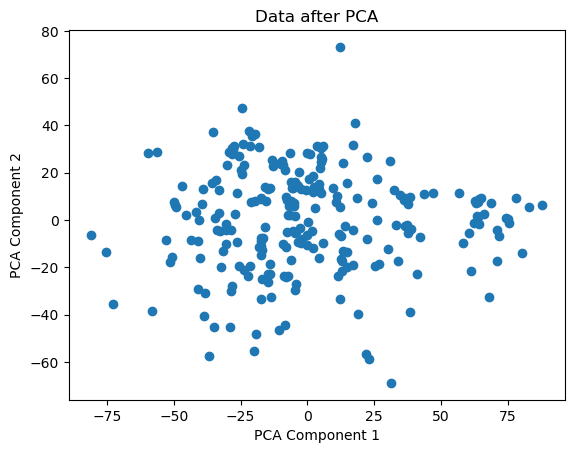

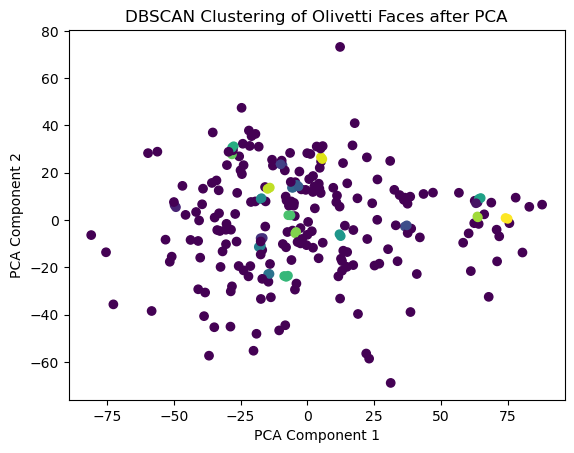

Best eps: 1.0
Best min_samples: 2
Estimated number of clusters: 21
Estimated number of noise points: 196
Best Silhouette Score: -0.4763016402721405
Best Davies-Bouldin Index: 2.007893245465484


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)  # Set random seed for reproducibility

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Apply PCA
pca = PCA(n_components=2, random_state=42)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)

# Visualize the data after PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('Data after PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Manual hyperparameter tuning for DBSCAN
best_eps = 0.5
best_min_samples = 5
best_n_clusters = 0
best_n_noise = len(X_train)
best_silhouette = -1
best_davies_bouldin = float('inf')

for eps in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    for min_samples in [2, 3, 5, 7, 10]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_pca)
        
        unique_labels = set(dbscan_labels)
        n_clusters = len(unique_labels) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        
        if n_clusters > 1:  # Silhouette score and Davies-Bouldin index are undefined for a single cluster
            silhouette_avg = silhouette_score(X_pca, dbscan_labels)
            davies_bouldin_avg = davies_bouldin_score(X_pca, dbscan_labels)
            
            if (n_clusters > best_n_clusters or 
                (n_clusters == best_n_clusters and n_noise < best_n_noise) or 
                (n_clusters == best_n_clusters and n_noise == best_n_noise and silhouette_avg > best_silhouette) or 
                (n_clusters == best_n_clusters and n_noise == best_n_noise and silhouette_avg == best_silhouette and davies_bouldin_avg < best_davies_bouldin)):
                best_eps = eps
                best_min_samples = min_samples
                best_n_clusters = n_clusters
                best_n_noise = n_noise
                best_silhouette = silhouette_avg
                best_davies_bouldin = davies_bouldin_avg

# Apply DBSCAN with the best hyperparameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(X_pca)

# Visualize clusters and noise points
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering of Olivetti Faces after PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Count the clusters and identify noisy points
unique_labels = set(dbscan_labels)
n_clusters = len(unique_labels) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")
print(f"Best Silhouette Score: {best_silhouette}")
print(f"Best Davies-Bouldin Index: {best_davies_bouldin}")

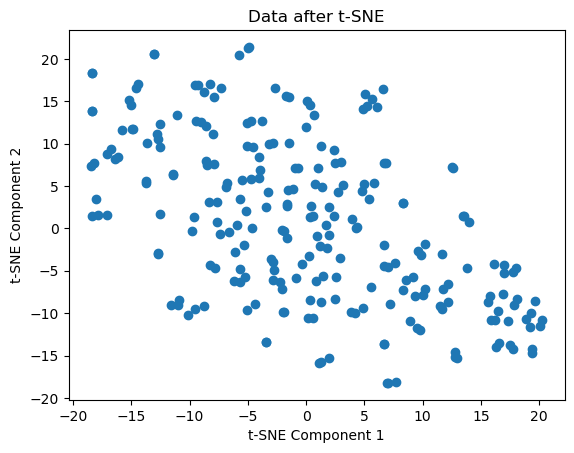

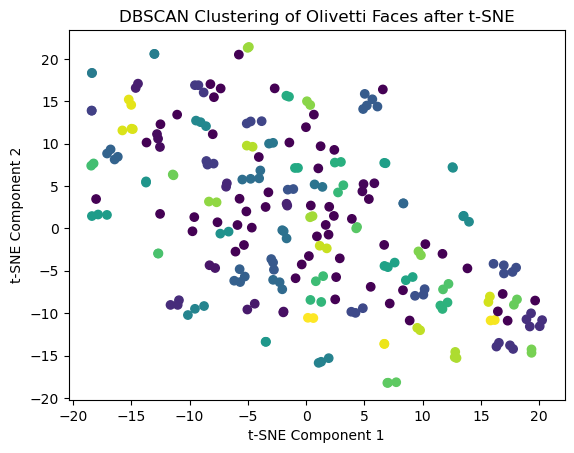

Best eps: 1.0
Best min_samples: 2
Estimated number of clusters: 73
Estimated number of noise points: 56
Best Silhouette Score: 0.3765229880809784
Best Davies-Bouldin Index: 1.3371950059216111


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)  # Set random seed for reproducibility

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)  # Reduce to 2 dimensions for visualization
X_tsne = tsne.fit_transform(X_scaled)

# Visualize the data after t-SNE
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('Data after t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Manual hyperparameter tuning for DBSCAN
best_eps = 0.5
best_min_samples = 5
best_n_clusters = 0
best_n_noise = len(X_train)
best_silhouette = -1
best_davies_bouldin = float('inf')

for eps in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    for min_samples in [2, 3, 5, 7, 10]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_tsne)
        
        unique_labels = set(dbscan_labels)
        n_clusters = len(unique_labels) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        
        if n_clusters > 1:  # Silhouette score and Davies-Bouldin index are undefined for a single cluster
            silhouette_avg = silhouette_score(X_tsne, dbscan_labels)
            davies_bouldin_avg = davies_bouldin_score(X_tsne, dbscan_labels)
            
            if (n_clusters > best_n_clusters or 
                (n_clusters == best_n_clusters and n_noise < best_n_noise) or 
                (n_clusters == best_n_clusters and n_noise == best_n_noise and silhouette_avg > best_silhouette) or 
                (n_clusters == best_n_clusters and n_noise == best_n_noise and silhouette_avg == best_silhouette and davies_bouldin_avg < best_davies_bouldin)):
                best_eps = eps
                best_min_samples = min_samples
                best_n_clusters = n_clusters
                best_n_noise = n_noise
                best_silhouette = silhouette_avg
                best_davies_bouldin = davies_bouldin_avg

# Apply DBSCAN with the best hyperparameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(X_tsne)

# Visualize clusters and noise points
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering of Olivetti Faces after t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Count the clusters and identify noisy points
unique_labels = set(dbscan_labels)
n_clusters = len(unique_labels) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")
print(f"Best Silhouette Score: {best_silhouette}")
print(f"Best Davies-Bouldin Index: {best_davies_bouldin}")